In [62]:
import sys
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint
from sklearn.metrics import confusion_matrix

sys.path.append('../utils')


In [48]:
data = pd.read_csv(
    '/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv'
).drop(columns='basemap_id')

In [49]:
# Remove Mosaiks from dataset for testing

mosaiks86 = data[
    [
        'inspection_id',
        'maj_landcover_code_x',
        'maj_landcover_code_y',
        'status',
        'structure_code',
        'current_month_rain',
        'previous_month_rain',
        'two_months_prior_rain',
        'mean_ndvi'
    ]
]

data = mosaiks86
data.columns


Index(['inspection_id', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain', 'mean_ndvi'],
      dtype='object')

In [50]:
print(data.shape)
print(data.columns)
data.head()

(67580, 9)
Index(['inspection_id', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain', 'mean_ndvi'],
      dtype='object')


,inspection_id,maj_landcover_code_x,maj_landcover_code_y,status,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,1,304.0,557,0,100,0.28,2.18,0.19,0.346535
1,2,304.0,304,0,101,1.46,0.08,3.19,0.463867
2,3,303.0,303,0,101,1.46,0.08,3.19,0.345345
3,4,39.0,304,0,100,1.46,0.08,3.19,0.278349
4,5,304.0,304,0,101,5.14,1.67,NaN,0.574557


## Downsample Majority Class Approach


In [51]:
# X = data.drop('status', axis=1)
# y = data['status']

# upsample_data_ids = X.inspection_id

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# train = pd.concat([X_train, y_train], axis=1)

# majority = train[train.status == 0]
# minority = train[train.status == 1]

# n_majority_desired = len(minority) * 3
# majority_downsampled = majority.sample(
#     n=n_majority_desired, replace=False, random_state=42
# )

# train_balanced = (
#     pd.concat([majority_downsampled, minority])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# X_train = train_balanced.drop('status', axis=1).drop(columns='inspection_id')
# y_train = train_balanced['status']

# X_test = X_test.drop(columns='inspection_id')

# print(f'Shape of compliant:', majority.shape)
# print(f'Shape of non-compliant:', minority.shape)

# print(f'N_minority desired:', int(len(majority) * 3))

# print('Shapes:')
# print(' Downsampled X_train:', X_train.shape)
# print(' Downsampled y_train:', y_train.shape)
# print(' Downsampled X_test: ', X_test.shape)
# print(' Downsampled y_test: ', y_test.shape)

# print('\nTrain distribution after up-sampling:')
# print(y_train.value_counts(normalize=True))

# X_train


## Upsample Minority Class Approach


In [52]:
X = data.drop('status', axis=1)
y = data['status']

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 18.75)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop('status', axis=1).drop(columns='inspection_id')
y_train = train_balanced['status']
X_test = X_test.drop(columns='inspection_id')

# Check majority/minority sizes
print(f'Shape of compliant:', majority.shape)
print(f'Shape of non-compliant:', minority.shape)

print(f'N_minority desired:', int(len(majority) / 3))

print('Shapes:')
print(' Upsampled X_train:', X_train.shape)
print(' Upsampled y_train:', y_train.shape)
print(' Upsampled X_test: ', X_test.shape)
print(' Upsampled y_test: ', y_test.shape)

print('\nTrain distribution after up-sampling:')
print(y_train.value_counts(normalize=True))

print("\nTest distribution after up-sampling:")
print(y_test.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 9)
Shape of non-compliant: (334, 9)
N_minority desired: 17910
Shapes:
 Upsampled X_train: (56595, 7)
 Upsampled y_train: (56595,)
 Upsampled X_test:  (13516, 7)
 Upsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.949377
1    0.050623
Name: proportion, dtype: float64

Test distribution after up-sampling:
status
0    0.993785
1    0.006215
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,582.0,582,102,0.01,0.51,0.92,0.088224
1,581.0,41,101,0.07,0.01,NaN,0.229570
2,582.0,582,102,0.35,NaN,6.69,0.249891
3,557.0,582,102,0.01,NaN,NaN,0.335957
4,581.0,556,102,0.07,0.01,NaN,0.295601
...,...,...,...,...,...,...,...
56590,304.0,304,102,NaN,NaN,0.02,0.299699
56591,556.0,304,102,NaN,NaN,NaN,0.299048
56592,581.0,581,102,0.26,1.37,NaN,0.225500
56593,NaN,581,102,2.24,0.07,0.01,0.191329


In [57]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = int(len(majority) * 0.9)
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

n_min = int(len(majority_downsampled) * 0.05)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority_downsampled, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority_downsampled) / 3))

print(f"Shape of compliant:", majority_downsampled.shape)
print(f"Shape of non-compliant:", minority_upsampled.shape)

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 9)
Shape of non-compliant: (334, 9)
N_minority desired: 16119
Shape of compliant: (48357, 9)
Shape of non-compliant: (2417, 9)
Shapes:
 Upsampled X_train: (50774, 7)
 Upsampled y_train: (50774,)
 Upsampled X_test:  (13516, 7)
 Upsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.952397
1    0.047603
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,mean_ndvi
0,304.0,304,100,NaN,NaN,0.28,0.357424
1,556.0,582,101,NaN,NaN,NaN,0.449168
2,582.0,582,102,0.03,0.01,0.02,0.283952
3,304.0,582,102,NaN,0.01,NaN,0.205963
4,41.0,304,101,NaN,0.24,2.48,0.496754
...,...,...,...,...,...,...,...
50769,582.0,557,102,1.09,NaN,NaN,0.273877
50770,304.0,303,102,NaN,NaN,NaN,0.349302
50771,581.0,556,102,0.07,0.01,NaN,0.216845
50772,582.0,303,102,0.06,1.88,0.16,-0.011619


## Random Forest Classifier Model


In [58]:
# If no upsampling or downsampling has been done, use this. 

# X = data.drop(["status", "inspection_id"], axis=1)
# y = data["status"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# X_test = X_test.drop(columns="inspection_id")


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': 19, 'max_features': 0.2, 'min_samples_leaf': 10, 'n_estimators': 180}
Actual non-compliant count: 84
Predicted non-compliant count: 920
Accuracy: 0.9282332050902634


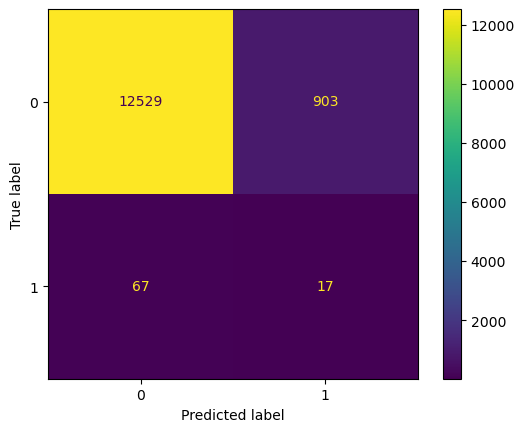

In [64]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', 0.2, 0.5],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

# Halving random search
halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    resource='n_estimators',
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=3,
    scoring='precision',
    n_jobs=1,
    verbose=1,
    refit=True,
)

halving_search.fit(X_train, y_train)
print('Best parameters:', halving_search.best_params_)

# Use the refitted best model
best_rf = halving_search.best_estimator_

# Predict with threshold
y_scores = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.1
y_pred = (y_scores >= threshold).astype(int)

# Metrics and confusion matrix
print(f'Actual non-compliant count: {y_test.sum()}')
print(f'Predicted non-compliant count: {y_pred.sum()}')
print('Accuracy:', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Feature importances:
 mean_ndvi                0.355096
maj_landcover_code_y     0.129731
two_months_prior_rain    0.122995
previous_month_rain      0.113538
current_month_rain       0.100251
dtype: float64


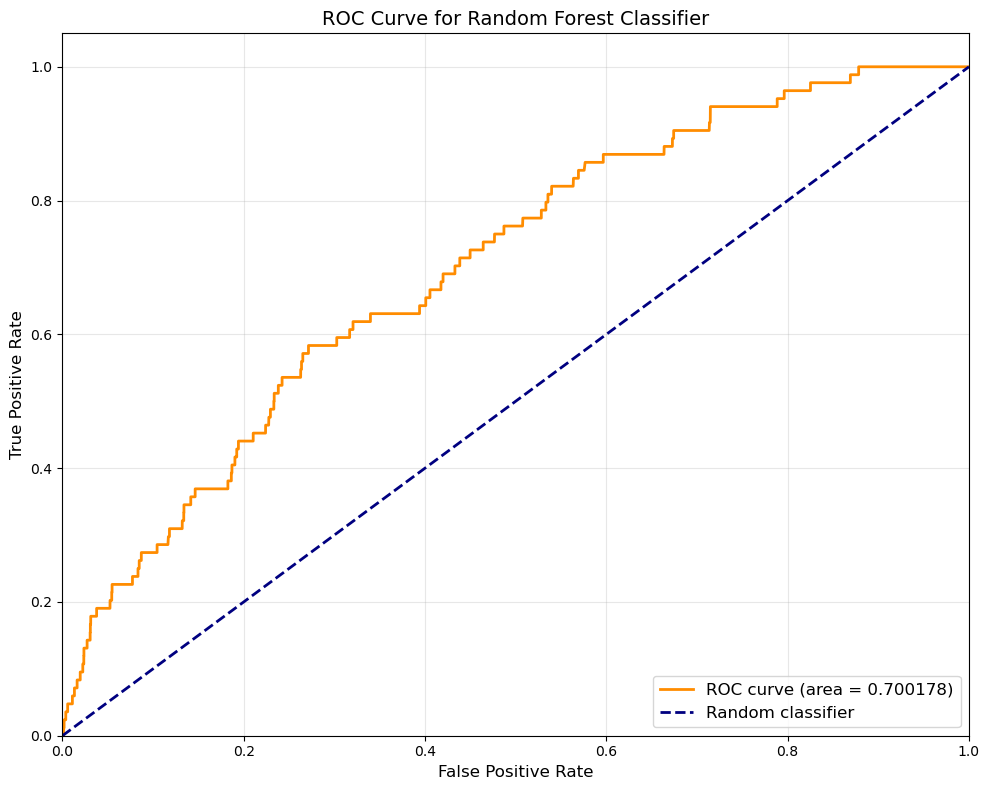

ROC AUC Score: 0.7002


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(f'Feature importances:\n', feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})')

# Plot baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Random Forest Classifier', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f'ROC AUC Score: {roc_auc:.4f}')


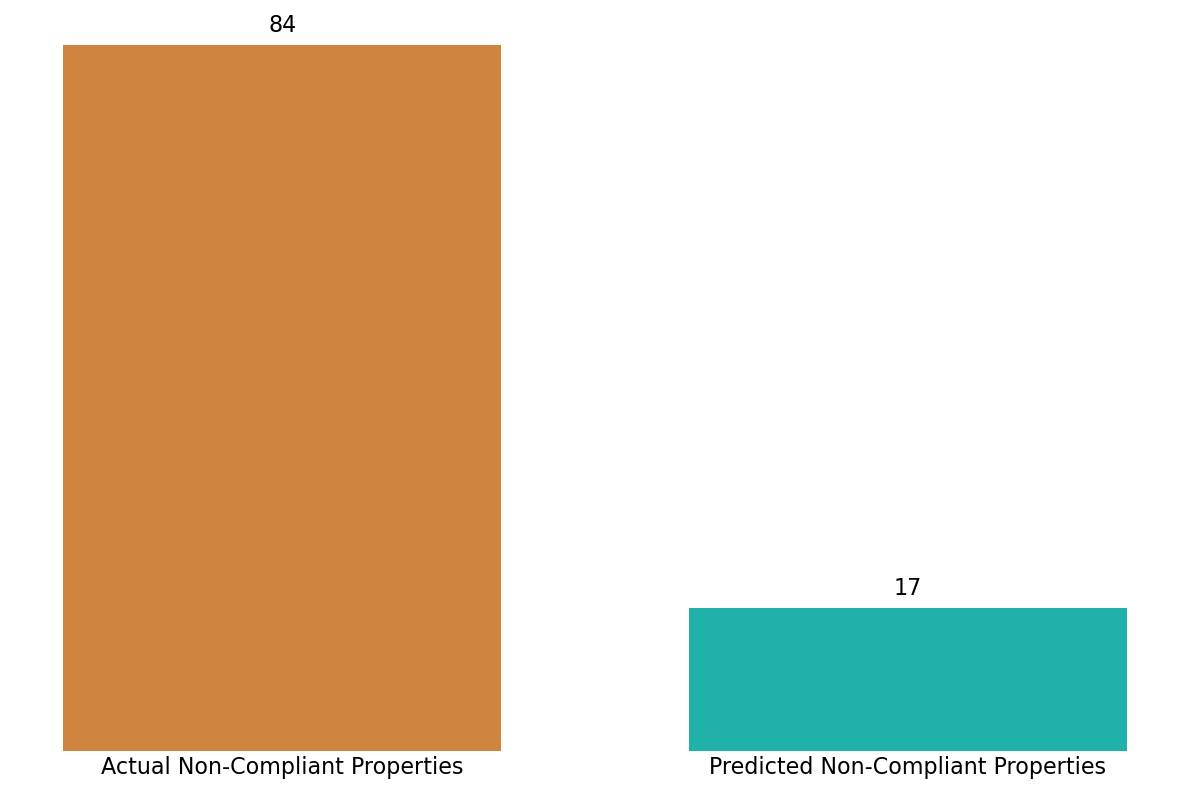

In [67]:
import matplotlib.pyplot as plt
import numpy as np

actual_noncompliant = cm[1].sum()
predicted_noncompliant = cm[1,1]

# Labels and positions
labels = ['Actual Non-Compliant Properties', 'Predicted Non-Compliant Properties']
x = np.array([0, 1])
width = 0.7

# Colors: orange for actual, steelblue for predicted
colors = ['peru', 'lightseagreen']

# Create figure & axes with transparent background
fig, ax = plt.subplots(figsize=(12, 8), facecolor='none')
ax.set_facecolor('none')
fig.patch.set_alpha(0)

# Remove frame
for spine in ax.spines.values():
    spine.set_visible(False)

# Plot bars
bars = ax.bar(x, [actual_noncompliant, predicted_noncompliant], width, color=colors)

# Add count labels on top
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, h + 1, f'{int(h)}', ha='center', va='bottom', fontsize = 16
    )

# Keep x-axis labels but hide the tick markers
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.tick_params(axis='x', length=0)

# Keep the y-axis title but hide tick marks and labels
ax.set_ylabel('')
ax.tick_params(axis='y', which='both', length=0, labelleft=False)

# (Optionally set a title)
ax.set_title('')

plt.tight_layout()
plt.show()
